In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import freqepid

In [5]:
# %load_ext jupyternotify

# 1. parameters

In [6]:
T = 120
T0 = 40

In [7]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [8]:
alpha = 0.01
r_Y = 10

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [9]:
d = 2
beta = np.array([0, -2.2])

In [10]:
r_I = 10
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [11]:
mu = np.log(100)

$$I_{[-T_0,0)} = \exp(\mu_0)$$

# 2. simulation

## load simulation

In [12]:
data = pd.read_feather('data/simulation_randinf.feather')

In [13]:
data_i = data[data['sim']==0]
A = np.stack([np.full(T, 1), data_i["intervention"].to_numpy()], -1)
R = data_i["R"].to_numpy()
EI = data_i["EI"].to_numpy()
I = data_i["infection"].to_numpy()
EY = data_i["EY"].to_numpy()
Y = data_i["death"].to_numpy()

In [14]:
data_i

,sim,date,R,EI,infection,EY,death,intervention
0,0,0,3.250000,324.997762,356.0,0.956069,0,0
1,0,1,3.250000,340.245831,298.0,0.962543,2,0
2,0,2,3.250000,392.196621,409.0,0.968283,0,0
3,0,3,3.250000,471.047829,545.0,0.973654,1,0
4,0,4,3.250000,581.900998,584.0,0.979752,1,0
...,...,...,...,...,...,...,...,...
115,0,115,0.648378,371.111321,316.0,15.952502,18,1
116,0,116,0.648378,353.729962,301.0,15.065929,6,1
117,0,117,0.648378,334.027910,314.0,14.232065,22,1
118,0,118,0.648378,313.305734,285.0,13.440178,20,1


# 3. fit by coordinate descent method

In [15]:
model = freqepid.Model(GPi['g'], GPi['pi'], alpha, K, T0, 'normal')

In [16]:
result = pd.read_feather('result_epidemia_normal_randinf.feather')

In [17]:
result

,R|(Intercept),R|intervention,death|(Intercept),seeds[1]
0,-0.246249,-1.88846,0.003521,143.0270
1,-0.335886,-1.83875,0.004007,218.6220
2,0.015900,-2.29427,0.003384,60.0293
3,-0.469547,-1.67336,-0.002757,351.9550
4,-0.098848,-2.11227,0.000028,91.2163
...,...,...,...,...
995,-0.218386,-1.94533,0.000756,138.0850
996,-0.044873,-2.18712,0.007965,70.4901
997,-0.143851,-2.02692,0.007246,98.6957
998,-0.170113,-2.05979,0.003207,124.6440


In [18]:
bsmp = result.iloc[:,:2].to_numpy()
msmp = np.log(result.iloc[:,3].to_numpy())

In [19]:
bepi = np.mean(bsmp,0)
mepi = np.mean(msmp)

In [20]:
mepi, bepi

(4.839649012931921, array([-0.19602393, -1.99099477]))

In [21]:
Repi = model.predict_R(A, bepi)
Iepi = model.predict_I(A, mepi, bepi)
EYepi = model.predict_EY(A, mepi, bepi)

## plots

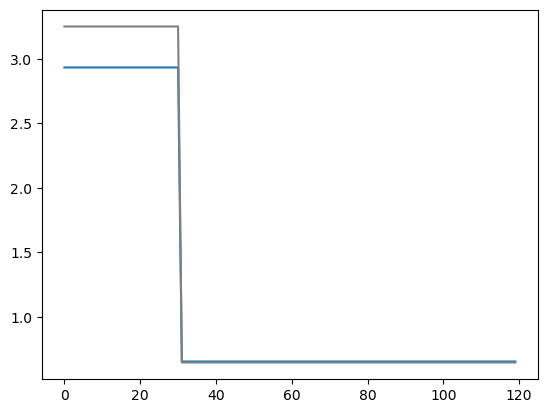

In [22]:
plt.plot(Repi)
plt.plot(R, color='grey')

<BarContainer object of 120 artists>

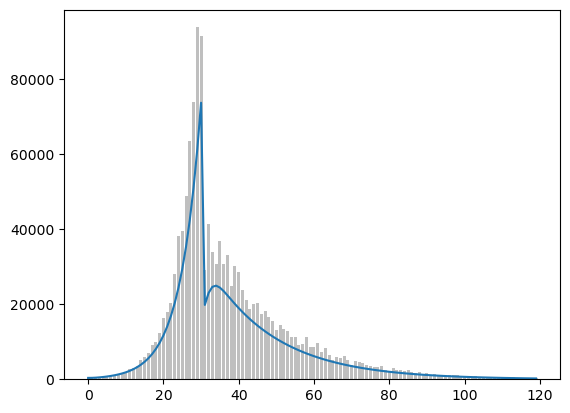

In [23]:
plt.plot(Iepi)
plt.bar(np.arange(T), I, color='grey', alpha=0.5)

<BarContainer object of 120 artists>

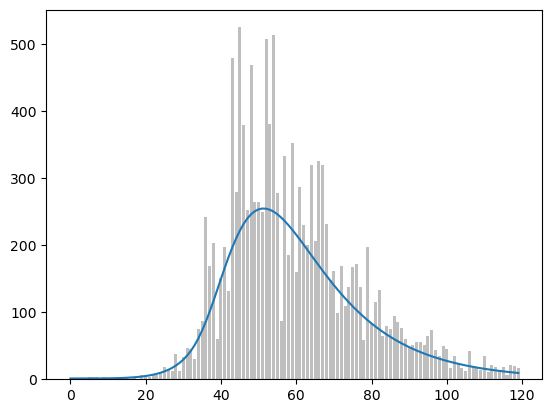

In [24]:
plt.plot(EYepi)
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)

# 4. Confidence Region

In [25]:
tsmp = np.concatenate([msmp[:,None], bsmp], -1)

In [34]:
theta = np.array([mu, *beta])
tepi = np.mean(tsmp, 0)
tname = [r"$\mu$", r"$\beta_0$", r"$\beta_1$"]
tlimit = [[3, 8], [-1, 0.5], [-3, -1]]

In [27]:
Vepi = np.cov(tsmp.T)

In [28]:
Vepi[-2:,-2:]

array([[ 0.01512654, -0.01920297],
       [-0.01920297,  0.02547176]])

In [29]:
chi_pa = freqepid.CV(d+1).chi_pa(0.05)

(-3.0, -1.0)

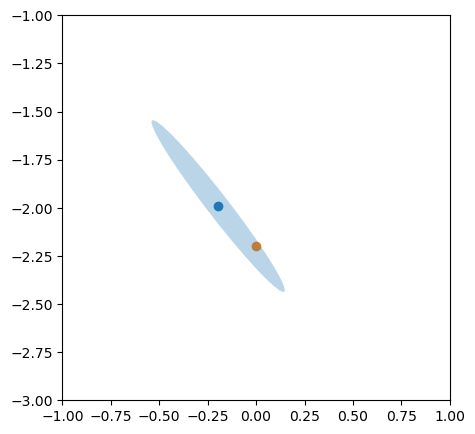

In [30]:
plt.figure(figsize=(5,5))
p = plt.scatter(*tepi[-2:])
plt.scatter(*beta)
freqepid.confidence_ellipse(
    tepi[-2:], Vepi[-2:,-2:], 
    n_std=chi_pa, facecolor=p.get_facecolor(), alpha=0.3)
plt.xlim(-1, 1); plt.ylim(-3,-1)

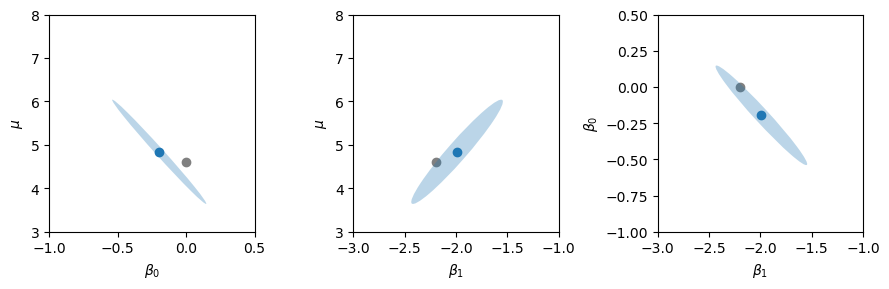

In [36]:
plt.figure(figsize=(9,3))
for i in np.arange(d+1):
    for j in np.arange(i+1,d+1):
        plt.subplot(1,3,i+j)
        p = plt.scatter(tepi[j], tepi[i])
        plt.scatter(theta[j], theta[i], color='grey')
        freqepid.confidence_ellipse(
            [tepi[j],tepi[i]], Vepi[np.ix_([j,i],[j,i])], 
            n_std=chi_pa, facecolor=p.get_facecolor(), alpha=0.3)
        plt.xlabel(tname[j]); plt.ylabel(tname[i])
        plt.xlim(tlimit[j]); plt.ylim(tlimit[i])
plt.tight_layout()

# 5. Confidence Band

In [37]:
conf_R, beta_min, beta_max = \
model.confidence_R(A, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.117sec.
optimization at t = 2 finished, lapse: 0.062sec.
optimization at t = 3 finished, lapse: 0.061sec.
optimization at t = 4 finished, lapse: 0.060sec.
optimization at t = 5 finished, lapse: 0.066sec.
optimization at t = 6 finished, lapse: 0.063sec.
optimization at t = 7 finished, lapse: 0.063sec.
optimization at t = 8 finished, lapse: 0.061sec.
optimization at t = 9 finished, lapse: 0.064sec.
optimization at t = 10 finished, lapse: 0.064sec.
optimization at t = 11 finished, lapse: 0.063sec.
optimization at t = 12 finished, lapse: 0.061sec.
optimization at t = 13 finished, lapse: 0.064sec.
optimization at t = 14 finished, lapse: 0.063sec.
optimization at t = 15 finished, lapse: 0.063sec.
optimization at t = 16 finished, lapse: 0.061sec.
optimization at t = 17 finished, lapse: 0.064sec.
optimization at t = 18 finished, lapse: 0.062sec.
optimization at t = 19 finished, lapse: 0.063sec.
optimization at t = 20 finished, lapse: 0.063sec.
optimizat

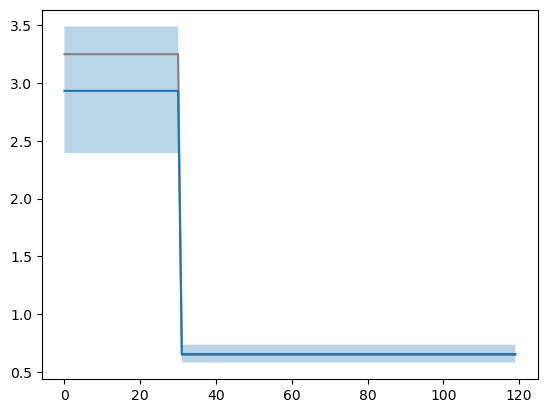

In [38]:
plt.plot(R, color='grey')
plt.plot(Repi)
plt.fill_between(np.arange(T), conf_R[:,0], conf_R[:,1], alpha=0.3)

In [39]:
conf_I, _, _ = \
model.confidence_I(A, mepi, bepi, Vepi[-3:,-3:], chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.114sec.
optimization at t = 2 finished, lapse: 0.116sec.
optimization at t = 3 finished, lapse: 0.107sec.
optimization at t = 4 finished, lapse: 0.177sec.
optimization at t = 5 finished, lapse: 0.109sec.
optimization at t = 6 finished, lapse: 0.112sec.
optimization at t = 7 finished, lapse: 0.109sec.
optimization at t = 8 finished, lapse: 0.103sec.
optimization at t = 9 finished, lapse: 0.109sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 10 finished, lapse: 0.211sec.
optimization at t = 11 finished, lapse: 0.113sec.
optimization at t = 12 finished, lapse: 0.106sec.
optimization at t = 13 finished, lapse: 0.114sec.
optimization at t = 14 finished, lapse: 0.143sec.
optimization at t = 15 finished, lapse: 0.218sec.
optimization at t = 16 finished, lapse: 0.213sec.
optimization at t = 17 finished, lapse: 0.299sec.
optimization at t = 18 finished, lapse: 0.205sec.
optimization at t = 19 finished, lapse: 0.246sec.
optimization at t = 20 finished, lapse: 0.211sec.
optimization at t = 21 finished, lapse: 0.231sec.
optimization at t = 22 finished, lapse: 0.346sec.
optimization at t = 23 finished, lapse: 0.369sec.
optimization at t = 24 finished, lapse: 0.317sec.
optimization at t = 25 finished, lapse: 0.336sec.
optimization at t = 26 finished, lapse: 0.558sec.
optimization at t = 27 finished, lapse: 0.366sec.
optimization at t = 28 finished, lapse: 0.518sec.
optimization at t = 29 finished, lapse: 0.384sec.


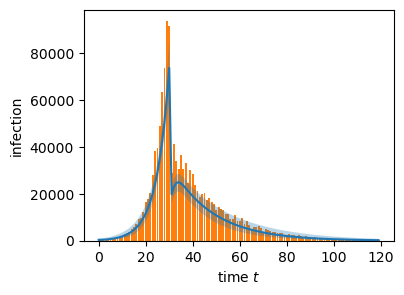

In [45]:
plt.figure(figsize = (4,3))
plt.xlabel("time $t$"); plt.ylabel("infection")
plt.bar(np.arange(T), I, color='C1')
plt.plot(Iepi)
plt.fill_between(np.arange(T), conf_I[:,0], conf_I[:,1], alpha=0.3)

In [41]:
conf_EY, theta_min, theta_max = \
model.confidence_EY(A, mepi, bepi, Vepi[-3:,-3:], chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 1.291sec.
optimization at t = 2 finished, lapse: 0.394sec.
optimization at t = 3 finished, lapse: 0.345sec.
optimization at t = 4 finished, lapse: 0.678sec.
optimization at t = 5 finished, lapse: 1.414sec.
optimization at t = 6 finished, lapse: 0.442sec.
optimization at t = 7 finished, lapse: 0.739sec.
optimization at t = 8 finished, lapse: 0.569sec.
optimization at t = 9 finished, lapse: 0.360sec.
optimization at t = 10 finished, lapse: 0.350sec.
optimization at t = 11 finished, lapse: 0.190sec.
optimization at t = 12 finished, lapse: 0.261sec.
optimization at t = 13 finished, lapse: 0.114sec.
optimization at t = 14 finished, lapse: 0.298sec.
optimization at t = 15 finished, lapse: 0.124sec.
optimization at t = 16 finished, lapse: 0.182sec.
optimization at t = 17 finished, lapse: 0.272sec.
optimization at t = 18 finished, lapse: 0.218sec.
optimization at t = 19 finished, lapse: 0.130sec.
optimization at t = 20 finished, lapse: 0.095sec.
optimizat

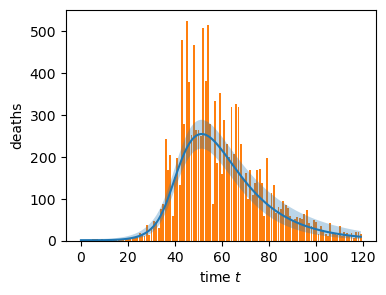

In [44]:
plt.figure(figsize = (4,3))
plt.xlabel("time $t$"); plt.ylabel("deaths")
plt.bar(np.arange(T), Y, color='C1')
plt.plot(EYepi)
plt.fill_between(np.arange(T), conf_EY[:,0], conf_EY[:,1], alpha=0.3)

# 6. Confidence Interval

## A = 1

In [45]:
Tf = 60
Af = np.zeros([Tf, d])

In [46]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 1)

In [47]:
Ae = np.concatenate([A, Af], 0)

In [48]:
conf_band, beta_min, beta_max = \
model.confidence_R(Ae, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.228sec.
optimization at t = 2 finished, lapse: 0.146sec.
optimization at t = 3 finished, lapse: 0.150sec.
optimization at t = 4 finished, lapse: 0.181sec.
optimization at t = 5 finished, lapse: 0.180sec.
optimization at t = 6 finished, lapse: 0.139sec.
optimization at t = 7 finished, lapse: 0.168sec.
optimization at t = 8 finished, lapse: 0.208sec.
optimization at t = 9 finished, lapse: 0.280sec.
optimization at t = 10 finished, lapse: 0.192sec.
optimization at t = 11 finished, lapse: 0.242sec.
optimization at t = 12 finished, lapse: 0.230sec.
optimization at t = 13 finished, lapse: 0.115sec.
optimization at t = 14 finished, lapse: 0.237sec.
optimization at t = 15 finished, lapse: 0.103sec.
optimization at t = 16 finished, lapse: 0.110sec.
optimization at t = 17 finished, lapse: 0.126sec.
optimization at t = 18 finished, lapse: 0.163sec.
optimization at t = 19 finished, lapse: 0.142sec.
optimization at t = 20 finished, lapse: 0.150sec.
optimizat

optimization at t = 165 finished, lapse: 0.158sec.
optimization at t = 166 finished, lapse: 0.136sec.
optimization at t = 167 finished, lapse: 0.206sec.
optimization at t = 168 finished, lapse: 0.170sec.
optimization at t = 169 finished, lapse: 0.187sec.
optimization at t = 170 finished, lapse: 0.171sec.
optimization at t = 171 finished, lapse: 0.138sec.
optimization at t = 172 finished, lapse: 0.174sec.
optimization at t = 173 finished, lapse: 0.213sec.
optimization at t = 174 finished, lapse: 0.157sec.
optimization at t = 175 finished, lapse: 0.172sec.
optimization at t = 176 finished, lapse: 0.244sec.
optimization at t = 177 finished, lapse: 0.225sec.
optimization at t = 178 finished, lapse: 0.153sec.
optimization at t = 179 finished, lapse: 0.162sec.
optimization at t = 180 finished, lapse: 0.136sec.


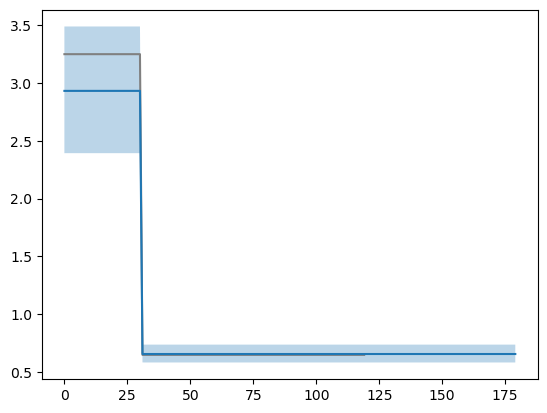

In [49]:
plt.plot(R, color='grey')
plt.plot(model.predict_R(Ae, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [50]:
conf_band, theta_min, theta_max = \
model.confidence_I(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.251sec.
optimization at t = 2 finished, lapse: 0.330sec.
optimization at t = 3 finished, lapse: 0.299sec.
optimization at t = 4 finished, lapse: 0.414sec.
optimization at t = 5 finished, lapse: 0.279sec.
optimization at t = 6 finished, lapse: 0.238sec.
optimization at t = 7 finished, lapse: 0.216sec.
optimization at t = 8 finished, lapse: 0.343sec.
optimization at t = 9 finished, lapse: 0.260sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 10 finished, lapse: 0.576sec.
optimization at t = 11 finished, lapse: 0.234sec.
optimization at t = 12 finished, lapse: 0.220sec.
optimization at t = 13 finished, lapse: 0.243sec.
optimization at t = 14 finished, lapse: 0.322sec.
optimization at t = 15 finished, lapse: 0.535sec.
optimization at t = 16 finished, lapse: 0.516sec.
optimization at t = 17 finished, lapse: 0.631sec.
optimization at t = 18 finished, lapse: 0.435sec.
optimization at t = 19 finished, lapse: 0.671sec.
optimization at t = 20 finished, lapse: 0.444sec.
optimization at t = 21 finished, lapse: 0.666sec.
optimization at t = 22 finished, lapse: 0.515sec.
optimization at t = 23 finished, lapse: 0.709sec.
optimization at t = 24 finished, lapse: 0.863sec.
optimization at t = 25 finished, lapse: 0.668sec.
optimization at t = 26 finished, lapse: 1.025sec.
optimization at t = 27 finished, lapse: 0.721sec.
optimization at t = 28 finished, lapse: 0.708sec.
optimization at t = 29 finished, lapse: 0.730sec.


optimization at t = 172 finished, lapse: 21.235sec.
optimization at t = 173 finished, lapse: 12.917sec.
optimization at t = 174 finished, lapse: 1102.846sec.
optimization at t = 175 finished, lapse: 21.036sec.
optimization at t = 176 finished, lapse: 980.728sec.
optimization at t = 177 finished, lapse: 18.177sec.
optimization at t = 178 finished, lapse: 65.753sec.
optimization at t = 179 finished, lapse: 21.734sec.
optimization at t = 180 finished, lapse: 1008.402sec.


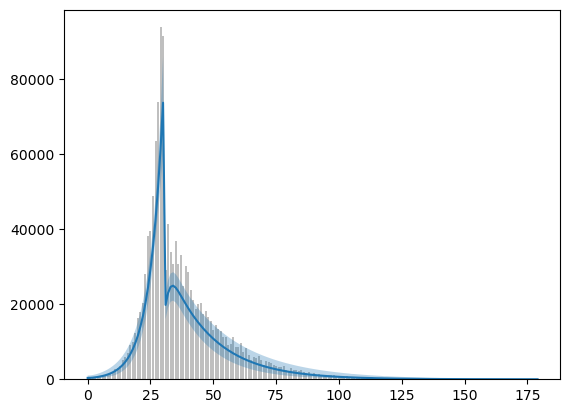

In [51]:
plt.bar(np.arange(T), I, color='grey', alpha=0.5)
plt.plot(model.predict_I(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [52]:
conf_band, theta_min, theta_max = \
model.confidence_EY(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 2.413sec.
optimization at t = 2 finished, lapse: 0.883sec.
optimization at t = 3 finished, lapse: 0.883sec.
optimization at t = 4 finished, lapse: 1.139sec.
optimization at t = 5 finished, lapse: 2.534sec.
optimization at t = 6 finished, lapse: 0.904sec.
optimization at t = 7 finished, lapse: 1.444sec.
optimization at t = 8 finished, lapse: 0.973sec.
optimization at t = 9 finished, lapse: 0.618sec.
optimization at t = 10 finished, lapse: 0.744sec.
optimization at t = 11 finished, lapse: 0.500sec.
optimization at t = 12 finished, lapse: 0.757sec.
optimization at t = 13 finished, lapse: 0.383sec.
optimization at t = 14 finished, lapse: 0.853sec.
optimization at t = 15 finished, lapse: 0.351sec.
optimization at t = 16 finished, lapse: 0.548sec.
optimization at t = 17 finished, lapse: 0.789sec.
optimization at t = 18 finished, lapse: 0.669sec.
optimization at t = 19 finished, lapse: 0.378sec.
optimization at t = 20 finished, lapse: 0.264sec.
optimizat

optimization at t = 163 finished, lapse: 16.904sec.
optimization at t = 164 finished, lapse: 19.677sec.
optimization at t = 165 finished, lapse: 15.955sec.
optimization at t = 166 finished, lapse: 18.419sec.
optimization at t = 167 finished, lapse: 18.048sec.
optimization at t = 168 finished, lapse: 23.845sec.
optimization at t = 169 finished, lapse: 9.703sec.
optimization at t = 170 finished, lapse: 9.854sec.
optimization at t = 171 finished, lapse: 10.795sec.
optimization at t = 172 finished, lapse: 39.815sec.
optimization at t = 173 finished, lapse: 15.894sec.
optimization at t = 174 finished, lapse: 25.838sec.
optimization at t = 175 finished, lapse: 18.282sec.
optimization at t = 176 finished, lapse: 16.370sec.
optimization at t = 177 finished, lapse: 27.950sec.
optimization at t = 178 finished, lapse: 21.702sec.
optimization at t = 179 finished, lapse: 1023.895sec.
optimization at t = 180 finished, lapse: 19.899sec.


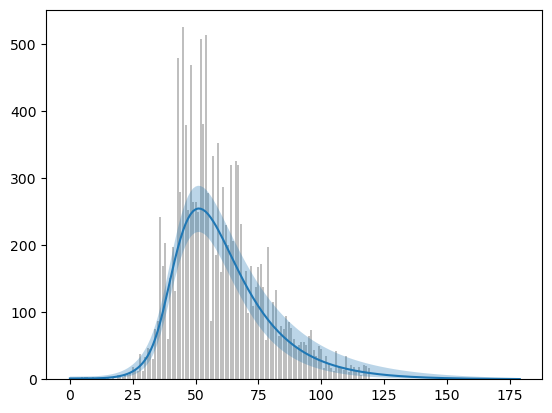

In [53]:
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)
plt.plot(model.predict_EY(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

## A = 0.5

In [54]:
Tf = 60
Af = np.zeros([Tf, d])

In [55]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [56]:
Ae = np.concatenate([A, Af], 0)

In [57]:
conf_band, beta_min, beta_max = \
model.confidence_R(Ae, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.274sec.
optimization at t = 2 finished, lapse: 0.085sec.
optimization at t = 3 finished, lapse: 0.165sec.
optimization at t = 4 finished, lapse: 0.156sec.
optimization at t = 5 finished, lapse: 0.182sec.
optimization at t = 6 finished, lapse: 0.153sec.
optimization at t = 7 finished, lapse: 0.160sec.
optimization at t = 8 finished, lapse: 0.153sec.
optimization at t = 9 finished, lapse: 0.149sec.
optimization at t = 10 finished, lapse: 0.175sec.
optimization at t = 11 finished, lapse: 0.141sec.
optimization at t = 12 finished, lapse: 0.152sec.
optimization at t = 13 finished, lapse: 0.141sec.
optimization at t = 14 finished, lapse: 0.155sec.
optimization at t = 15 finished, lapse: 0.162sec.
optimization at t = 16 finished, lapse: 0.133sec.
optimization at t = 17 finished, lapse: 0.168sec.
optimization at t = 18 finished, lapse: 0.152sec.
optimization at t = 19 finished, lapse: 0.150sec.
optimization at t = 20 finished, lapse: 0.143sec.
optimizat

optimization at t = 164 finished, lapse: 0.312sec.
optimization at t = 165 finished, lapse: 0.239sec.
optimization at t = 166 finished, lapse: 0.210sec.
optimization at t = 167 finished, lapse: 0.258sec.
optimization at t = 168 finished, lapse: 0.297sec.
optimization at t = 169 finished, lapse: 0.326sec.
optimization at t = 170 finished, lapse: 0.248sec.
optimization at t = 171 finished, lapse: 0.246sec.
optimization at t = 172 finished, lapse: 0.218sec.
optimization at t = 173 finished, lapse: 0.227sec.
optimization at t = 174 finished, lapse: 0.384sec.
optimization at t = 175 finished, lapse: 0.220sec.
optimization at t = 176 finished, lapse: 0.265sec.
optimization at t = 177 finished, lapse: 0.226sec.
optimization at t = 178 finished, lapse: 0.239sec.
optimization at t = 179 finished, lapse: 0.232sec.
optimization at t = 180 finished, lapse: 0.215sec.


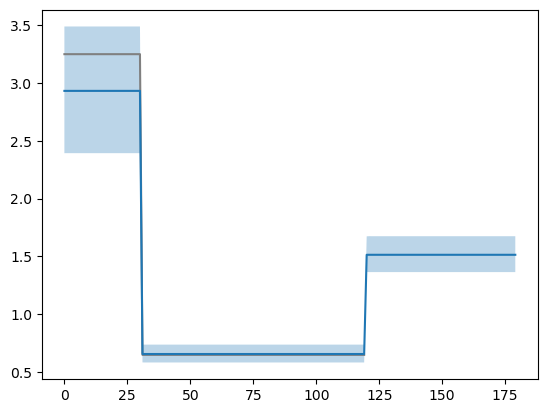

In [58]:
plt.plot(R, color='grey')
plt.plot(model.predict_R(Ae, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [59]:
conf_band, theta_min, theta_max = \
model.confidence_I(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.293sec.
optimization at t = 2 finished, lapse: 0.319sec.
optimization at t = 3 finished, lapse: 0.255sec.
optimization at t = 4 finished, lapse: 0.482sec.
optimization at t = 5 finished, lapse: 0.312sec.
optimization at t = 6 finished, lapse: 0.275sec.
optimization at t = 7 finished, lapse: 0.274sec.
optimization at t = 8 finished, lapse: 0.271sec.
optimization at t = 9 finished, lapse: 0.254sec.
optimization at t = 10 finished, lapse: 0.507sec.
optimization at t = 11 finished, lapse: 0.249sec.
optimization at t = 12 finished, lapse: 0.251sec.
optimization at t = 13 finished, lapse: 0.303sec.
optimization at t = 14 finished, lapse: 0.332sec.
optimization at t = 15 finished, lapse: 0.636sec.
optimization at t = 16 finished, lapse: 0.423sec.
optimization at t = 17 finished, lapse: 0.760sec.
optimization at t = 18 finished, lapse: 0.478sec.
optimization at t = 19 finished, lapse: 0.567sec.
optimization at t = 20 finished, lapse: 0.634sec.
optimizat

optimization at t = 163 finished, lapse: 66.672sec.
optimization at t = 164 finished, lapse: 169.681sec.
optimization at t = 165 finished, lapse: 56.221sec.
optimization at t = 166 finished, lapse: 35.975sec.
optimization at t = 167 finished, lapse: 29.930sec.
optimization at t = 168 finished, lapse: 25.576sec.
optimization at t = 169 finished, lapse: 42.119sec.
optimization at t = 170 finished, lapse: 51.705sec.
optimization at t = 171 finished, lapse: 112.601sec.
optimization at t = 172 finished, lapse: 96.387sec.
optimization at t = 173 finished, lapse: 22.048sec.
optimization at t = 174 finished, lapse: 19.917sec.
optimization at t = 175 finished, lapse: 8.223sec.
optimization at t = 176 finished, lapse: 55.062sec.
optimization at t = 177 finished, lapse: 14.700sec.
optimization at t = 178 finished, lapse: 11.791sec.
optimization at t = 179 finished, lapse: 10.151sec.
optimization at t = 180 finished, lapse: 38.562sec.


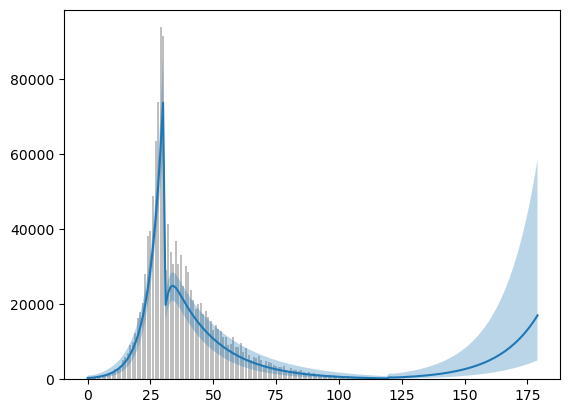

In [60]:
plt.bar(np.arange(T), I, color='grey', alpha=0.5)
plt.plot(model.predict_I(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [61]:
conf_band, theta_min, theta_max = \
model.confidence_EY(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 1.064sec.
optimization at t = 2 finished, lapse: 0.302sec.
optimization at t = 3 finished, lapse: 0.249sec.
optimization at t = 4 finished, lapse: 0.446sec.
optimization at t = 5 finished, lapse: 0.885sec.
optimization at t = 6 finished, lapse: 1027.136sec.
optimization at t = 7 finished, lapse: 0.478sec.
optimization at t = 8 finished, lapse: 0.345sec.
optimization at t = 9 finished, lapse: 0.261sec.
optimization at t = 10 finished, lapse: 0.279sec.
optimization at t = 11 finished, lapse: 0.220sec.
optimization at t = 12 finished, lapse: 0.317sec.
optimization at t = 13 finished, lapse: 0.130sec.
optimization at t = 14 finished, lapse: 0.342sec.
optimization at t = 15 finished, lapse: 0.139sec.
optimization at t = 16 finished, lapse: 0.212sec.
optimization at t = 17 finished, lapse: 0.309sec.
optimization at t = 18 finished, lapse: 0.263sec.
optimization at t = 19 finished, lapse: 0.156sec.
optimization at t = 20 finished, lapse: 0.109sec.
optimi

optimization at t = 164 finished, lapse: 279.791sec.
optimization at t = 165 finished, lapse: 5.332sec.
optimization at t = 166 finished, lapse: 5.102sec.
optimization at t = 167 finished, lapse: 6.771sec.
optimization at t = 168 finished, lapse: 7.358sec.
optimization at t = 169 finished, lapse: 8.833sec.
optimization at t = 170 finished, lapse: 799.762sec.
optimization at t = 171 finished, lapse: 9.108sec.
optimization at t = 172 finished, lapse: 8.151sec.
optimization at t = 173 finished, lapse: 11.132sec.
optimization at t = 174 finished, lapse: 4.545sec.
optimization at t = 175 finished, lapse: 8.487sec.
optimization at t = 176 finished, lapse: 15.425sec.
optimization at t = 177 finished, lapse: 10.481sec.
optimization at t = 178 finished, lapse: 13.315sec.
optimization at t = 179 finished, lapse: 7.144sec.
optimization at t = 180 finished, lapse: 5.066sec.


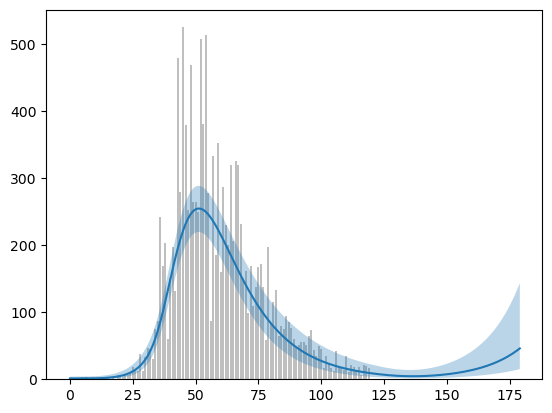

In [62]:
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)
plt.plot(model.predict_EY(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

## A = 0

In [63]:
Tf = 60
Af = np.zeros([Tf, d])

In [64]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0)

In [65]:
Ae = np.concatenate([A, Af], 0)

In [66]:
conf_band, beta_min, beta_max = \
model.confidence_R(Ae, bepi, Vepi[-2:,-2:], chi_pa,
                   verbose=True)

optimization at t = 1 finished, lapse: 0.094sec.
optimization at t = 2 finished, lapse: 0.053sec.
optimization at t = 3 finished, lapse: 0.054sec.
optimization at t = 4 finished, lapse: 0.051sec.
optimization at t = 5 finished, lapse: 0.052sec.
optimization at t = 6 finished, lapse: 0.050sec.
optimization at t = 7 finished, lapse: 0.051sec.
optimization at t = 8 finished, lapse: 0.050sec.
optimization at t = 9 finished, lapse: 0.050sec.
optimization at t = 10 finished, lapse: 0.051sec.
optimization at t = 11 finished, lapse: 0.051sec.
optimization at t = 12 finished, lapse: 0.050sec.
optimization at t = 13 finished, lapse: 0.050sec.
optimization at t = 14 finished, lapse: 0.049sec.
optimization at t = 15 finished, lapse: 0.052sec.
optimization at t = 16 finished, lapse: 0.050sec.
optimization at t = 17 finished, lapse: 0.050sec.
optimization at t = 18 finished, lapse: 0.050sec.
optimization at t = 19 finished, lapse: 0.050sec.
optimization at t = 20 finished, lapse: 0.053sec.
optimizat

optimization at t = 166 finished, lapse: 0.051sec.
optimization at t = 167 finished, lapse: 0.049sec.
optimization at t = 168 finished, lapse: 0.049sec.
optimization at t = 169 finished, lapse: 0.048sec.
optimization at t = 170 finished, lapse: 0.049sec.
optimization at t = 171 finished, lapse: 0.050sec.
optimization at t = 172 finished, lapse: 0.049sec.
optimization at t = 173 finished, lapse: 0.049sec.
optimization at t = 174 finished, lapse: 0.050sec.
optimization at t = 175 finished, lapse: 0.049sec.
optimization at t = 176 finished, lapse: 0.051sec.
optimization at t = 177 finished, lapse: 0.049sec.
optimization at t = 178 finished, lapse: 0.049sec.
optimization at t = 179 finished, lapse: 0.048sec.
optimization at t = 180 finished, lapse: 0.048sec.


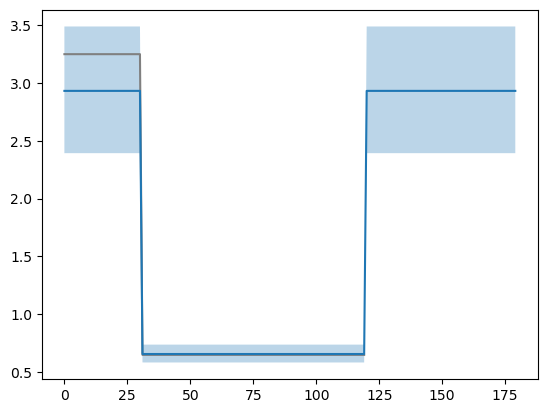

In [67]:
plt.plot(R, color='grey')
plt.plot(model.predict_R(Ae, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [68]:
conf_band, theta_min, theta_max = \
model.confidence_I(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.094sec.
optimization at t = 2 finished, lapse: 0.087sec.
optimization at t = 3 finished, lapse: 0.080sec.
optimization at t = 4 finished, lapse: 0.132sec.
optimization at t = 5 finished, lapse: 0.085sec.
optimization at t = 6 finished, lapse: 0.083sec.
optimization at t = 7 finished, lapse: 0.084sec.
optimization at t = 8 finished, lapse: 0.079sec.
optimization at t = 9 finished, lapse: 0.085sec.
optimization at t = 10 finished, lapse: 0.161sec.
optimization at t = 11 finished, lapse: 0.086sec.
optimization at t = 12 finished, lapse: 0.080sec.
optimization at t = 13 finished, lapse: 0.087sec.
optimization at t = 14 finished, lapse: 0.109sec.
optimization at t = 15 finished, lapse: 0.165sec.
optimization at t = 16 finished, lapse: 0.160sec.
optimization at t = 17 finished, lapse: 0.229sec.
optimization at t = 18 finished, lapse: 0.155sec.
optimization at t = 19 finished, lapse: 0.190sec.
optimization at t = 20 finished, lapse: 0.158sec.
optimizat

optimization at t = 163 finished, lapse: 1029.981sec.
optimization at t = 164 finished, lapse: 15.908sec.
optimization at t = 165 finished, lapse: 34.114sec.
optimization at t = 166 finished, lapse: 1003.518sec.
optimization at t = 167 finished, lapse: 21.298sec.
optimization at t = 168 finished, lapse: 9.625sec.
optimization at t = 169 finished, lapse: 9.750sec.
optimization at t = 170 finished, lapse: 11.261sec.
optimization at t = 171 finished, lapse: 9.015sec.
optimization at t = 172 finished, lapse: 23.330sec.
optimization at t = 173 finished, lapse: 132.665sec.
optimization at t = 174 finished, lapse: 22.829sec.
optimization at t = 175 finished, lapse: 518.199sec.
optimization at t = 176 finished, lapse: 24.489sec.
optimization at t = 177 finished, lapse: 425.015sec.
optimization at t = 178 finished, lapse: 20.847sec.
optimization at t = 179 finished, lapse: 2378.972sec.
optimization at t = 180 finished, lapse: 13.309sec.


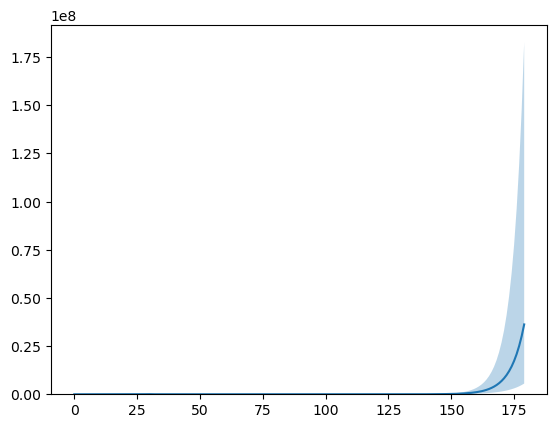

In [69]:
plt.bar(np.arange(T), I, color='grey', alpha=0.5)
plt.plot(model.predict_I(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

In [70]:
conf_band, theta_min, theta_max = \
model.confidence_EY(Ae, mepi, bepi, Vepi, chi_pa,
                    verbose=True)

optimization at t = 1 finished, lapse: 0.810sec.
optimization at t = 2 finished, lapse: 0.262sec.
optimization at t = 3 finished, lapse: 0.226sec.
optimization at t = 4 finished, lapse: 0.398sec.
optimization at t = 5 finished, lapse: 0.805sec.
optimization at t = 6 finished, lapse: 0.282sec.
optimization at t = 7 finished, lapse: 0.438sec.
optimization at t = 8 finished, lapse: 0.318sec.
optimization at t = 9 finished, lapse: 0.239sec.
optimization at t = 10 finished, lapse: 0.242sec.
optimization at t = 11 finished, lapse: 0.197sec.
optimization at t = 12 finished, lapse: 0.274sec.
optimization at t = 13 finished, lapse: 0.120sec.
optimization at t = 14 finished, lapse: 0.313sec.
optimization at t = 15 finished, lapse: 0.128sec.
optimization at t = 16 finished, lapse: 0.192sec.
optimization at t = 17 finished, lapse: 0.289sec.
optimization at t = 18 finished, lapse: 0.229sec.
optimization at t = 19 finished, lapse: 0.137sec.
optimization at t = 20 finished, lapse: 0.100sec.
optimizat

optimization at t = 164 finished, lapse: 62.349sec.
optimization at t = 165 finished, lapse: 62.063sec.
optimization at t = 166 finished, lapse: 60.403sec.
optimization at t = 167 finished, lapse: 13.526sec.
optimization at t = 168 finished, lapse: 15.934sec.
optimization at t = 169 finished, lapse: 8.856sec.
optimization at t = 170 finished, lapse: 13.156sec.
optimization at t = 171 finished, lapse: 20.632sec.
optimization at t = 172 finished, lapse: 27.210sec.
optimization at t = 173 finished, lapse: 13.252sec.
optimization at t = 174 finished, lapse: 17.363sec.
optimization at t = 175 finished, lapse: 16.836sec.
optimization at t = 176 finished, lapse: 9.224sec.
optimization at t = 177 finished, lapse: 16.180sec.
optimization at t = 178 finished, lapse: 8.438sec.
optimization at t = 179 finished, lapse: 1.829sec.
optimization at t = 180 finished, lapse: 1.523sec.


(0.0, 2000.0)

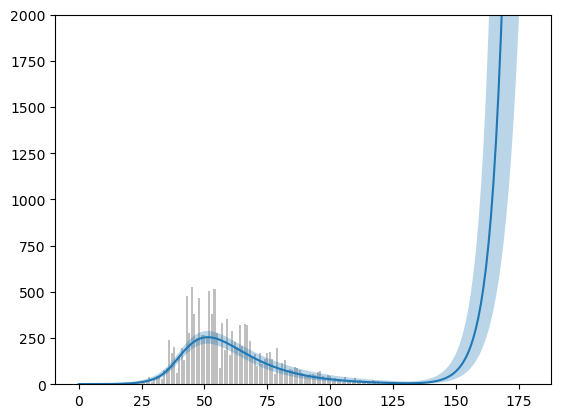

In [71]:
plt.bar(np.arange(T), Y, color='grey', alpha=0.5)
plt.plot(model.predict_EY(Ae, mepi, bepi))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)
plt.ylim(0,2000)